In [322]:
import tensorflow as tf 
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [323]:
nifty = pd.read_csv("NIFTY_50_5_Year_His_Data.csv")
nyse = pd.read_csv("NYSE_5_Year_His_Data.csv")

df_nifty = pd.DataFrame(nifty)
df_nyse = pd.DataFrame(nyse)

df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])
df_nyse['Date'] = pd.to_datetime(df_nyse['Date'])

df_nifty.set_index('Date', inplace=True)
df_nyse.set_index('Date', inplace=True)

common_dates = df_nifty.index.intersection(df_nyse.index)
df_nifty_common = df_nifty.loc[common_dates]
df_nyse_common = df_nyse.loc[common_dates]

df_nifty_common['return'] = df_nifty_common['Close'].pct_change()
df_nyse_common['return'] = df_nyse_common['Close'].pct_change()

# Drop NaNs from pct_change
returns_nifty = df_nifty_common['return'].dropna()
returns_nyse = df_nyse_common['return'].dropna()

# Align shapes
min_len = min(len(returns_nifty), len(returns_nyse))
returns_nifty = returns_nifty[-min_len:]
returns_nyse = returns_nyse[-min_len:]

# Build datasets
lookback = 30
x_data = []
y_data = []
for i in range(lookback, len(returns_nyse)):
    x_data.append(returns_nyse.iloc[i - lookback:i].values)
    y_data.append([returns_nifty.iloc[i]])

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

# Train-test split
split = int(0.8 * len(x_data))
x_train, x_val = x_data[:split], x_data[split:]
y_train, y_val = y_data[:split], y_data[split:]


C:\Users\kumar\AppData\Local\Temp\ipykernel_10444\3331651453.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])


In [324]:
lookback = 30
X, Y = [], []

returns_nyse = df_nyse_common['return'].values
returns_nifty = df_nifty_common['return'].values

for i in range(lookback, len(returns_nyse) - 1):
    X.append(returns_nyse[i-lookback:i])
    Y.append(returns_nifty[i+1])

X = np.array(X)
Y = np.array(Y).reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

In [325]:
# Hyperparameters
T = 1000
beta_start = 1e-4
beta_end = 0.02
embedding_dim = 32
input_dim = 30

In [326]:
# Noise Schedule
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars_np = np.cumprod(alphas).astype(np.float32)
alpha_bars = tf.convert_to_tensor(alpha_bars_np, dtype=tf.float32)


In [327]:
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = tf.exp(
        -tf.math.log(10000.0) * tf.range(0, half, dtype=tf.float32) / (half - 1)
    )
    angles = tf.cast(timesteps, tf.float32)[:, None] * freqs[None, :]
    emb = tf.concat([tf.sin(angles), tf.cos(angles)], axis=1)
    return emb

In [328]:
# # Residual LSTM Denoising Model
# def get_denoise_model():
#     t_input = Input(shape=(1,), name='t_input')
#     nyse_input = Input(shape=(30,), name='nyse_input')
#     y_t_input = Input(shape=(1,), name='y_t_input')

#     t_emb = layers.Dense(32, activation='relu')(t_input)
#     x = layers.Concatenate()([t_emb, nyse_input])
#     x = layers.Reshape((1, 62))(x)

#     lstm_out = layers.LSTM(64, return_sequences=True)(x)
#     skip = lstm_out  # Save for residual

#     lstm_out = layers.LSTM(64, return_sequences=False)(lstm_out)
#     x = layers.Concatenate()([lstm_out, y_t_input])
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dense(1)(x)

#     return Model(inputs=[y_t_input, t_input, nyse_input], outputs=x)


In [329]:
# Simple MLP Denoising Network
def get_denoise_model1():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    x = layers.Concatenate()([y_t_input, t_input, nyse_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)

    return Model([y_t_input, t_input, nyse_input], out)

In [330]:
# Feedforward Residual Network
def get_denoise_model2():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    nyse_proj = layers.Dense(64, activation='relu')(nyse_input)
    x = layers.Concatenate()([y_t_input, t_input, nyse_proj]) 

    # Project to residual dimension
    x_proj = layers.Dense(128)(x)  # match residual block size

    # Residual Block 1
    h = layers.Dense(128, activation='relu')(x_proj)
    h = layers.Dropout(0.1)(h)
    h = layers.Dense(128)(h)
    x = layers.Add()([x_proj, h])
    x = layers.Activation('relu')(x)

    # Residual Block 2
    h = layers.Dense(128, activation='relu')(x)
    h = layers.Dropout(0.1)(h)
    h = layers.Dense(128)(h)
    x = layers.Add()([x, h])
    x = layers.Activation('relu')(x)
    
    out = layers.Dense(1)(x)

    return Model([y_t_input,t_input,nyse_input],out)

In [331]:
# Forward Pass
def q_sample(y_0,t,noise):
    a_bar = tf.gather(alpha_bars,t)
    a_bar = tf.reshape(a_bar,(-1,1))
    return tf.sqrt(a_bar)*y_0+tf.sqrt(1.-a_bar)*noise

In [332]:
#  Training Step
def train_step(model,optimizer,x_batch,y_batch):
    batch_size = tf.shape(x_batch)[0]
    t = tf.random.uniform((batch_size,),minval=0,maxval=T,dtype=tf.int32)
    t_emb = get_timestep_embedding(t.numpy(),embedding_dim)

    noise = tf.random.normal(shape=tf.shape(y_batch))
    y_t = q_sample(y_batch,t,noise)

    with tf.GradientTape() as tape:
        pred_noise = model([y_t,t_emb,x_batch],training=True)
        loss = tf.reduce_mean(tf.square(pred_noise-noise))
    
    grads = tape.gradient(loss,model.trainable_weights)
    optimizer.apply_gradients(zip(grads,model.trainable_weights))
    
    return loss

In [333]:
#  DDIM Sampling
def ddim_sample(model,x_cond,eta=0.0):
    batch_size = tf.shape(x_cond)[0]
    y_t = tf.random.normal((batch_size, 1))

    for i in reversed(range(1, T)):
        batch_size = tf.shape(x_cond)[0]
        t = tf.fill([batch_size], i)  # shape (234,)
        t_emb = get_timestep_embedding(t, embedding_dim)
        # t_emb = tf.repeat(t_emb, repeats=batch_size, axis=0)

        pred_noise = model([y_t, t_emb, x_cond], training=False)

        a_bar = tf.gather(alpha_bars, t)
        a_bar_prev = tf.gather(alpha_bars, t-1)

        a_bar = tf.reshape(a_bar, (-1, 1))
        a_bar_prev = tf.reshape(a_bar_prev, (-1, 1))

        y_0 = (y_t - tf.sqrt(1. - a_bar) * pred_noise) / tf.sqrt(a_bar)
        y_t = tf.sqrt(a_bar_prev) * y_0 + tf.sqrt(1. - a_bar_prev) * pred_noise

    return y_0

In [334]:
#  Training 

model1 = get_denoise_model1()
model2 = get_denoise_model2()
optimizer1 = Adam(learning_rate=1e-3)
optimizer2 = Adam(learning_rate=1e-3)

nyse_scaler = StandardScaler()
nse_scaler = StandardScaler()

x_train = nyse_scaler.fit_transform(x_train)
x_val = nyse_scaler.transform(x_val)

y_train = nse_scaler.fit_transform(y_train)
y_val = nse_scaler.transform(y_val)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(64)
x_val_batch = tf.convert_to_tensor(x_val, dtype=tf.float32)

num_epochs = 100
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model1, optimizer1, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model2, optimizer2, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Epoch 1: Loss = 0.5390
Epoch 2: Loss = 0.6240
Epoch 3: Loss = 0.3765
Epoch 4: Loss = 0.4232
Epoch 5: Loss = 0.5645
Epoch 6: Loss = 0.3811
Epoch 7: Loss = 0.1902
Epoch 8: Loss = 0.3608
Epoch 9: Loss = 0.2107
Epoch 10: Loss = 0.2153
Epoch 11: Loss = 0.3330
Epoch 12: Loss = 0.3493
Epoch 13: Loss = 0.3238
Epoch 14: Loss = 0.3801
Epoch 15: Loss = 0.5427
Epoch 16: Loss = 0.2006
Epoch 17: Loss = 0.1363
Epoch 18: Loss = 0.2256
Epoch 19: Loss = 0.5965
Epoch 20: Loss = 0.5612
Epoch 21: Loss = 0.2079
Epoch 22: Loss = 0.2672
Epoch 23: Loss = 0.4080
Epoch 24: Loss = 0.3022
Epoch 25: Loss = 0.2779
Epoch 26: Loss = 0.3877
Epoch 27: Loss = 0.1849
Epoch 28: Loss = 0.2389
Epoch 29: Loss = 0.2725
Epoch 30: Loss = 0.2739
Epoch 31: Loss = 0.5346
Epoch 32: Loss = 0.2391
Epoch 33: Loss = 0.1680
Epoch 34: Loss = 0.2678
Epoch 35: Loss = 0.2842
Epoch 36: Loss = 0.3317
Epoch 37: Loss = 0.4171
Epoch 38: Loss = 0.1822
Epoch 39: Loss = 0.1895
Epoch 40: Loss = 0.1724
Epoch 41: Loss = 0.3157
Epoch 42: Loss = 0.1184
E

Model 1 -> MSE: 0.000501, MAE: 0.013809
Drift-Adjusted MSE: 0.000502, MAE: 0.013840
Drift-Adjusted Directional Accuracy: 51.71%


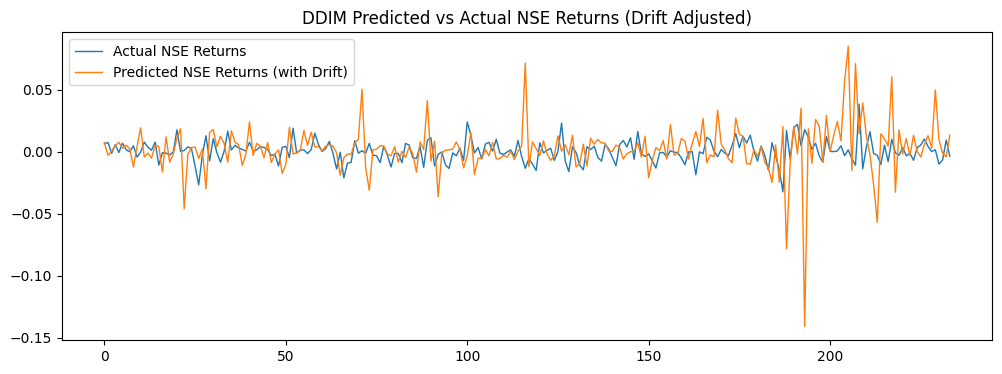

In [343]:
# Evaluation 
preds = ddim_sample(model1, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 1 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()



Model 2 -> MSE: 0.000151, MAE: 0.008874
Drift-Adjusted MSE: 0.000151, MAE: 0.008936
Drift-Adjusted Directional Accuracy: 55.56%


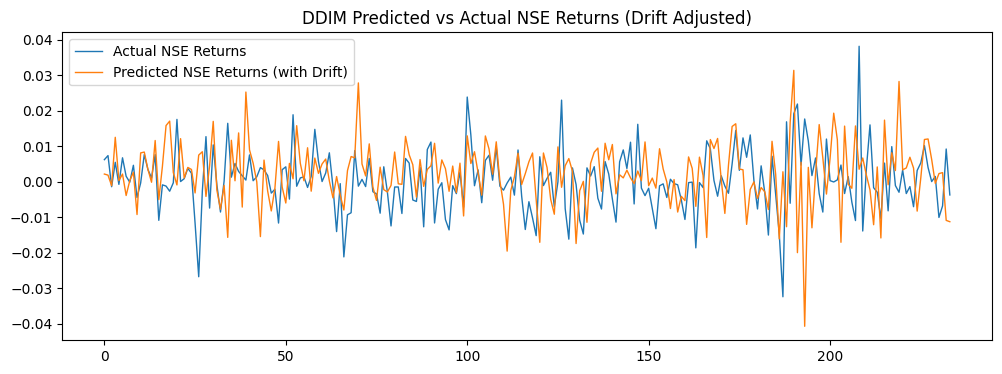

In [342]:
preds = ddim_sample(model2, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 2 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()


In [337]:
# embedding_dim = 32
# input_dim = 30

# def get_denoise_model_mlp():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     nyse_input = Input(shape=(input_dim,))

#     nyse_proj = layers.Dense(64, activation='relu')(nyse_input)
#     x = layers.Concatenate()([y_t_input, t_input, nyse_proj]) 

#     x_proj = layers.Dense(128)(x)

#     # Residual Block 1
#     h = layers.Dense(128, activation='relu')(x_proj)
#     h = layers.Dropout(0.1)(h)
#     h = layers.Dense(128)(h)
#     x = layers.Add()([x_proj, h])
#     x = layers.Activation('relu')(x)

#     # Residual Block 2
#     h = layers.Dense(128, activation='relu')(x)
#     h = layers.Dropout(0.1)(h)
#     h = layers.Dense(128)(h)
#     x = layers.Add()([x, h])
#     x = layers.Activation('relu')(x)
    
#     out = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, nyse_input], out)

# def get_denoise_model_lstm():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     nyse_input = Input(shape=(input_dim,))

#     nyse_seq = layers.Reshape((input_dim, 1))(nyse_input)
#     nyse_lstm = layers.LSTM(64)(nyse_seq)

#     x = layers.Concatenate()([y_t_input, t_input, nyse_lstm])
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.1)(x)
#     x = layers.Dense(64, activation='relu')(x)
#     out = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, nyse_input], out)

# def get_denoise_model_attention():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     nyse_input = Input(shape=(input_dim,))

#     nyse_seq = layers.Reshape((input_dim, 1))(nyse_input)
#     attn = layers.MultiHeadAttention(num_heads=2, key_dim=1)(nyse_seq, nyse_seq)
#     attn = layers.GlobalAveragePooling1D()(attn)

#     x = layers.Concatenate()([y_t_input, t_input, attn])
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.1)(x)
#     x = layers.Dense(64, activation='relu')(x)
#     out = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, nyse_input], out)

# "Models ready."


In [338]:
# models = {
#     'MLP': get_denoise_model_mlp(),
#     'LSTM': get_denoise_model_lstm(),
#     'Attention': get_denoise_model_attention()
# }

# train_dataset = tf.data.Dataset.from_tensor_slices(
#     ((y_t_train, t_emb_train, x_cond_train), noise_train)
# ).batch(32).shuffle(1024)

# val_dataset = tf.data.Dataset.from_tensor_slices(
#     ((y_t_val, t_emb_val, x_cond_val), noise_val)
# ).batch(32)

# histories = {}
# for name, model in models.items():
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     print(f"\nTraining {name} model...")
#     history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)
#     histories[name] = history
